In [ ]:
%%capture 
    #Suppresses output
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -u -p /usr/local 
import os
if os.path.isdir('/content/anaconda'): root_path = '/content/anaconda'
else: root_path = '/usr/local/'
os.environ['PATH'] += f":{root_path}/bin"
!conda create -n mp -c conda-forge pymeep python=3.7 -y
print(">> ", root_path)
import sys
sys.path.append(f'{root_path}envs/mp/lib/python3.7/site-packages/')

# Meep installation, as the packages are updated there might be problems

In [ ]:
%%capture
!sudo apt-get install hdf5-tools
!sudo apt-get install h5utils

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import meep as mp

plt.rc('font', size=19)          # controls default text sizes

In [ ]:
cell=mp.Vector3(16,8,0)  #Uses meep units

In [ ]:
geometry = [mp.Block(
    # This is a fiber, large index of refraction

    # Shape
    mp.Vector3(mp.inf, .4, mp.inf),
    # Position
    center = mp.Vector3(0,0,0),
    # Material property
    material=mp.Medium(epsilon=12.)
)]

source = [mp.Source(
    # Oscillating source in time
    mp.ContinuousSource(frequency=1/1.55),
    # Oscillates in z axis
    component = mp.Ez,
    # Position
    center = mp.Vector3(-7., 0, 0)
)]

# PML layer is a layer of wave absorption
# Fields in this layer will be reduced
pml_layers = [mp.PML(thickness = 1.0)]

# Resolution, meaning that the spatial step is 1/resolution MUL
resolution = 10

     block, center = (0,0,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


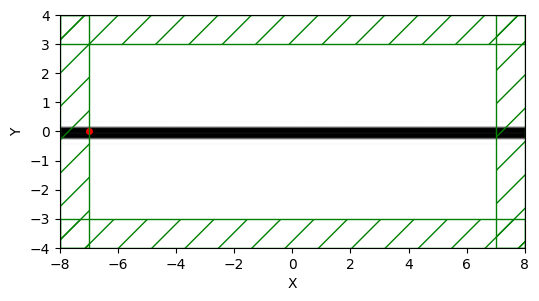

In [ ]:
# Reset the simulation when it is redefined
# Note that it seems to crash the kernel if you try and redefine a simulation without resetting the fields first
try:
    sim.reset_meep()
except NameError:
    pass

sim = mp.Simulation(
	  cell_size=cell,
	  boundary_layers = pml_layers,
	  geometry = geometry,
	  sources = source,
	  resolution = resolution
)

# Plot the simulation to ensure what we are doing is correct
plt.figure(dpi=100)
sim.plot2D()

plt.show()

In [ ]:
sim.run(until=100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.046932 s
-----------


FloatProgress(value=0.0, description='0% done ')

run 0 finished at t = 100.0 (2000 timesteps)


     block, center = (0,0.4,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.4,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


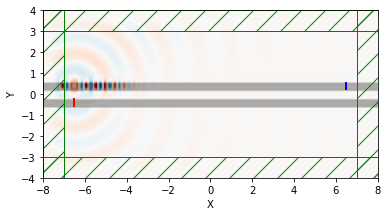

In [ ]:
# Make a plot of the electric field at the end of the simulation
ez_data = sim.get_array(size=cell, center=mp.Vector3(), component=mp.Ez)

fig = plt.figure()
ax = plt.axes()
sim.plot2D()
#plt.imshow(ez_data.transpose(), cmap='RdBu', extent=[-8, 8, -4, 4], alpha=0.7)
plt.imshow(ez_data.transpose(), cmap='RdBu', extent=[*ax.get_xlim(), *ax.get_ylim()], alpha=0.7)
    # Allows for plot overlap, fetch the limits from sim.plot2D()
    # The * in front of variables unpacks them
    # NOTE: this still flips y-axis (see how imshow() reads this)
        # Below I have this plot with correct orientation
plt.show()

# Note, due to the losses, this is not a monomodal waveguide (see photonics course)

In [ ]:
sim.reset_meep()

sim.run(
    mp.at_beginning(mp.output_epsilon),
    mp.to_appended("ez", mp.at_every(3, mp.output_efield_z)),
    until=100
)
# This saves to a file
# Note that the name of the epsilon is 
# dependent on the time of the simulation

-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.038837 s
-----------


FloatProgress(value=0.0, description='0% done ')

creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 2 finished at t = 100.0 (2000 timesteps)


In [ ]:
# Must be read externally (.h5 format), here we use bash
# Print the string inside ez
!h5ls ez.h5

In [ ]:
# Format the string
!var=$( h5ls ez.h5 | awk '{print $5}'|sed 's/ \/Inf\} / /g')

!var2=$((var-1))
!echo $var2

# Convert to png
!h5topng -t 0:$var2 -R -S 3 -Zc dkbluered -a yarg -A $1 eps-000000.00.h5 ez.h5

# Part 2, after the break

     block, center = (0,0,0)
          size (16,8,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


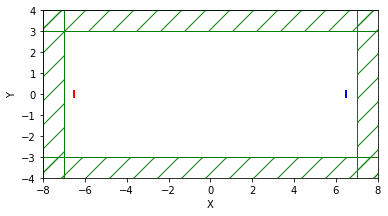

In [ ]:
cell = mp.Vector3(16,8,0)
pml_layers = [mp.PML(1.0)]
resolution = 10

#Clean all the values of the field from the simulation
try:
    sim.reset_meep()
except NameError:
    pass

norma = 1   # norma = 1 removes the waveguide
if norma:
    # No waveguide
    geometry=[mp.Block(
        mp.Vector3(16,8,mp.inf),   # All infinities should work
        # Here it matches the universe of simulation
        center = mp.Vector3(0,0,0),
        material = mp.Medium(epsilon=1.0)
    )]
else:
    # Waveguide
    geometry=[mp.Block(
        mp.Vector3(mp.inf,0.4,mp.inf),
        center = mp.Vector3(0,0,0),
        material = mp.Medium(epsilon=12.0)
    )]    

# Here we use a gaussian source
fcen = 1/1.55   #0.65
df = 0.2        # 1/3 of frequency is reasonable
nfreq = 500
source = [mp.Source(
    mp.GaussianSource(fcen, fwidth=df),
    component = mp.Ez,
    center = mp.Vector3(-6.5,0,0),
    size = mp.Vector3(0., 0.3, 0.)
)]    

sim = mp.Simulation(
	  cell_size=cell,
	  boundary_layers = pml_layers,
	  geometry = geometry,
	  sources = source,
	  resolution = resolution
)

# Place a detector
# Note that it is an FFT integration over time of the Poynting vector
trans_fr = mp.FluxRegion(
    center = mp.Vector3(6.5,0,0),
    # Detector on the right side
    size = mp.Vector3(0,0.3,0)
)

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
sim.plot2D()
plt.show()

In [ ]:
sim.run(
    mp.at_beginning(mp.output_epsilon),
    mp.to_appended("ez", mp.at_every(2,mp.output_efield_z)),
    until = 100
)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000231981 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (16,8,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.086921 s
-----------


FloatProgress(value=0.0, description='0% done ')

creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 100.0 (2000 timesteps)


In [ ]:
!var=$( h5ls ez.h5 | awk '{print $5}'|sed 's/ \/Inf\} / /g')

!var2=$((var-1))
!echo $var2

!h5topng -t 0:$var2 -R -S 3 -Zc dkbluered -a yarg -A $1 ez.h5 eps-000000.00.h5
# Careful of renormalization of colors, some pixels might be very bright

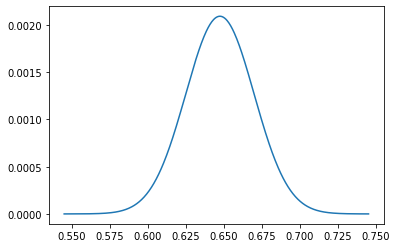

In [ ]:
freqs = mp.get_flux_freqs(tran)
if(norma):
    meas_flux0 = mp.get_fluxes(tran)
    plt.plot(freqs,meas_flux0)
else:
    meas_flux1 = mp.get_fluxes(tran)
    plt.plot(freqs,meas_flux1)

Note: the two values should both be preserved to take the ratio between the two values and get the transmission of the waveguide

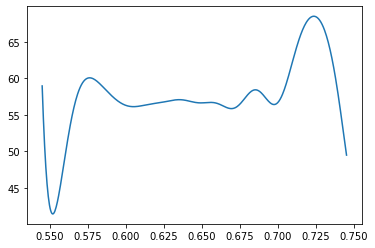

In [ ]:
## Plot the ratio
plt.plot(freqs, np.array(meas_flux1)/np.array(meas_flux0))

Can see that the transmission is much higher than 1, as the waveguide collects the field and brings it to the detector

Note the drop at low frequency, associated with higher wavelengths that can escape the waveguide.

NOTE: if the intensity is too close to 0, it might be unwise to approach the problem like this

FOR NEXT WEEK: model a directional coupler, that is 2 waveguides coupled along their lengths (see notes)

# Part 3 (at home): Directional coupler

     block, center = (0,0.35,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.35,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


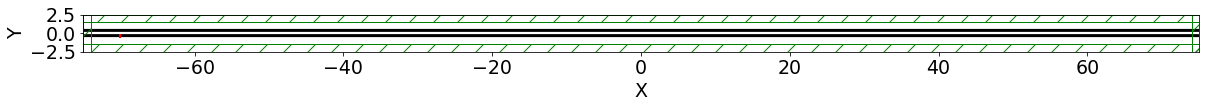

In [ ]:
xmax = 150

cell = mp.Vector3(xmax,5,0)
pml_layers = [mp.PML(1.0)]
resolution = 10

try:
    sim.reset_meep()
except NameError:
    pass

separation = 0.3
width = 0.4

geometry=[
    # Waveguide 1
    mp.Block(
    mp.Vector3(mp.inf,width,mp.inf),
    center = mp.Vector3(0,(separation+width)/2,0),
    material = mp.Medium(epsilon=12.0)
    ),
    # Waveguide 2
    mp.Block(
    mp.Vector3(mp.inf,width,mp.inf),
    center = mp.Vector3(0,-(separation+width)/2,0),
    material = mp.Medium(epsilon=12.0)
    )
]

source = [mp.Source(
    mp.ContinuousSource(frequency=1/1.55),
    component = mp.Ez,
    center = mp.Vector3(-xmax/2+5,-(separation+width)/2,0),
    size = mp.Vector3(0., 0.3, 0.)
)]    

sim = mp.Simulation(
	  cell_size=cell,
	  boundary_layers = pml_layers,
	  geometry = geometry,
	  sources = source,
	  resolution = resolution
)

# No need for a detector, could try and move a detector until we find a 0, but no need
"""# Need to measure how much field goes through a detector with or without the waveguide
trans_fr = mp.FluxRegion(
    center = mp.Vector3(18,(separation+width)/2,0),
    # Detector on the right side
    size = mp.Vector3(0,0.3,0)
)

tran = sim.add_flux(1/1.55, 0.1, nfreq, trans_fr)"""
fig = plt.figure(figsize=[20,20])
sim.plot2D()
plt.show()

In [ ]:
sim.run(until = 1000)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00468707 s
Working in 2D dimensions.
Computational cell is 150 x 5 x 0 with resolution 10
     block, center = (0,0.35,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.35,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.226146 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 227.25/1000.0 = 22.7% done in 4.0s, 13.6s to go
on time step 4550 (time=227.5), 0.000879203 s/step
Meep progress: 462.5/1000.0 = 46.2% done in 8.0s, 9.3s to go
on time step 9259 (time=462.95), 0.000849481 s/step
Meep progress: 700.0500000000001/1000.0 = 70.0% done in 12.0s, 5.1s to go
on time step 14011 (time=700.55), 0.000841968 s/step
Meep progress: 929.25/1000.0 = 92.9% done in 16.0s, 1.2s to go
on time step 18598 (time=929.9), 0.000872057 s/step
run 0 finished at t = 1000.0 (20000 timesteps)


     block, center = (0,0.4,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-0.4,0)
          size (1e+20,0.4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


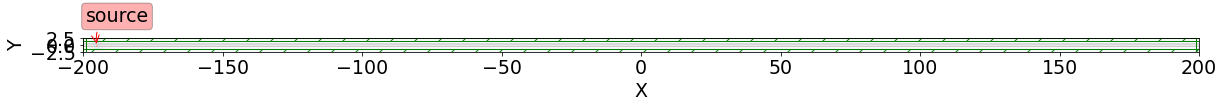

In [ ]:
# Make a plot of the electric field at the end of the simulation
ez_data = sim.get_array(size=cell, center=mp.Vector3(), component=mp.Ez)
# by_data = sim.get_array(size=cell, center=mp.Vector3(), component=mp.By)
# Ed_data = ez_data**2*12+((by_data+np.roll(by_data, -1))/2)**2
    # Doesn't work, need better interpolation on field data due to low resolution

fig = plt.figure(figsize=[20,3])
ax = plt.axes()
sim.plot2D(fields = mp.Ez, labels=True)
#plt.imshow(ez_data.transpose()[::-1], cmap='RdBu', extent=[*ax.get_xlim(), *ax.get_ylim()], alpha=0.7)
plt.savefig("CouplerFields.svg", format = "svg", bbox_inches='tight')

plt.show()

**Strat 1: use energy density and find the zeroes**

(-75.0, 74.9)

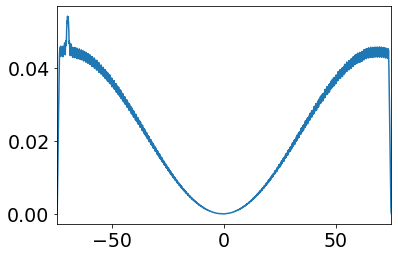

In [ ]:
xvals_ed = np.zeros(xmax*resolution)
EnergyDensity = np.zeros(xmax*resolution)
# Must be readjusted to slices
for i in range(0,xmax*resolution):
    xvals_ed[i] = -xmax/2+i/resolution
    VolWG2 = mp.Volume(center = mp.Vector3(xvals_ed[i],-(separation+width)/2,0), size = mp.Vector3(1, 0.3, 0.))
    EnergyDensity[i]=sim.field_energy_in_box(box = VolWG2)

plt.plot(xvals_ed, EnergyDensity)
plt.xlim(min(xvals_ed), max(xvals_ed))
# Graph is noisy even using energy density, not sure why
    # Probably due to grid discretization
    # Not a big problem, still less noisy than E field

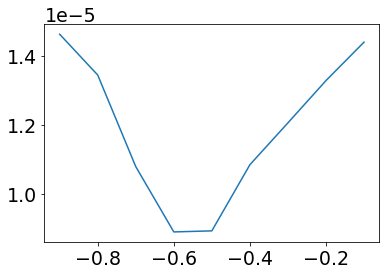

In [ ]:
# Zoom to the minimum for a better estimate
low = -1
high = 0

cond = np.logical_and((xvals_ed < high), (xvals_ed > low))
plt.plot(xvals_ed[cond], EnergyDensity[cond])

In [ ]:
print(-0.6 + xmax/2 - 5)

69.4


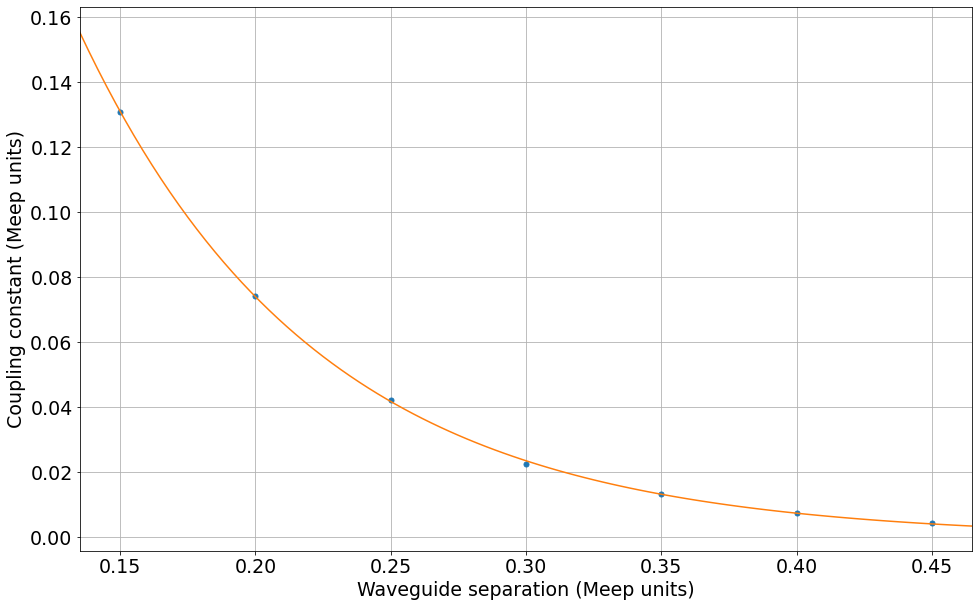

(array([ 8.77150780e-02,  7.25327487e-01, -1.88058516e-04]),
 array([[ 1.53429660e-06, -2.00831393e-05, -5.87835387e-07],
        [-2.00831393e-05,  2.75700391e-04,  6.94609632e-06],
        [-5.87835387e-07,  6.94609632e-06,  3.13268748e-07]]))

In [ ]:
# Written by hand
Lc = {0.15 : 12.0, 0.20 : 21.2, 0.25: 37.1, 0.3 : 69.4, 0.35 : 119.4, 0.4 : 207.2, 0.45 : 365}
distances = np.array(list(Lc.keys()))
couplingL = np.array([Lc[i] for i in distances])
ks = np.pi/2/couplingL

model= lambda t, L, a, b: [a*np.exp(-x/L)+b for x in t]
fit=scipy.optimize.curve_fit(model, distances, ks, method = 'trf', p0 = [1, 100, 0])

fig = plt.figure(figsize = [16,10])
ax = plt.axes()
plt.plot(distances, ks, ls = " ", marker = ".", markersize = 10)

xmargins = np.linspace(*ax.get_xlim(), 100)
plt.xlim(*ax.get_xlim())
plt.plot(xmargins, model(xmargins, *fit[0]))
plt.grid()
plt.xlabel("Waveguide separation (Meep units)")
plt.ylabel("Coupling constant (Meep units)")
plt.savefig("kvsSeparation.svg", format = "svg", bbox_inches='tight')
plt.show()

fit

In [ ]:
fit[0], np.sqrt(np.diag(fit[1]))

(array([ 8.77150780e-02,  7.25327487e-01, -1.88058516e-04]),
 array([0.00123867, 0.01660423, 0.0005597 ]))

Looks close to an exponential.
$$k=\frac{2}{\pi L_C} = A~exp\left(-\frac{separation}{0.086\mu m}\right)$$
using $\epsilon = 12$ and $width = 0.4 \mu m$

Note: if I use multimodal waveguides I get beat effects between the modes
I can use eigensource to inject a fundamental mode into the waveguide

**Strat 2: use electric field and perform a fit**

In [ ]:
# For comfort, fetch a grid of field values
xvals=np.linspace(-cell[0]/2, cell[0]/2, int(resolution*cell[0]))
yvals=np.linspace(-cell[1]/2, cell[1]/2, int(resolution*cell[1]))

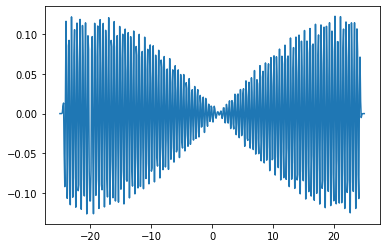

In [ ]:
# Extract a small strip of the field inside the first waveguide
cond = np.logical_and((yvals < -separation-width/10), (yvals > -separation-width*9/10))
ez_data_wg1 = ez_data[:,cond]
ez_data_wg1 = np.mean(ez_data_wg1, 1) #ez_data_wg1[:,1]

plt.plot(xvals, ez_data_wg1)


In [ ]:
# Can fit directly to time constant
startfit = 30
endfit = -30


model = lambda x, k_low, k_high, A, u0, u1: [A*np.sin(k_low*(u-u0))*np.cos(k_high*(u-u1)) for u in x]

fit=scipy.optimize.curve_fit(
    model,
    xvals[startfit:endfit], ez_data_wg1[startfit:endfit],
    p0 = [2*np.pi/1.55*12, np.pi/20/2, 0.1, 1, 1],
        # The first frequency is the oscillation due to dipole 2*pi*f*n
        # The second frequency is coupling constant
        # Each factor needs a phase, and an overall amplitude
    method = 'trf',
    )
print((fit[0][0]-2*np.pi/1.55**12)/2*np.pi/1.55**12)
fit[0]

0.3977642961058794


array([48.72789002,  0.10847401,  0.06527059,  1.02201989, -9.60463543])

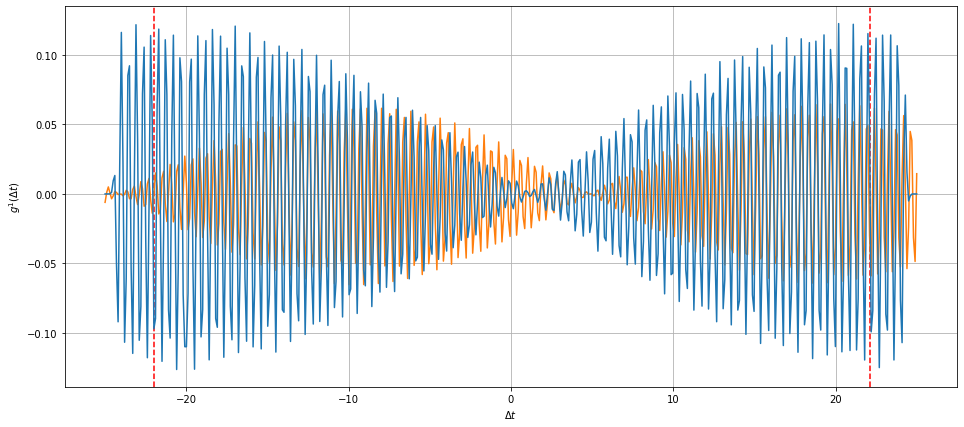

In [ ]:
# Plot of goodness of fit

fig = plt.figure(figsize = [16,7])
ax=plt.axes()
plt.errorbar(xvals, ez_data_wg1)
#plt.xscale('log')
#plt.ylim(0.8,2)

# Vertical line at last point fitted
ax.axvline(xvals[startfit], color="r", ls="--")
ax.axvline(xvals[endfit], color="r", ls="--")

# Plotting the model
plt.plot(xvals, model(xvals,*fit[0]))
plt.grid()
plt.xlabel("$\Delta t$")
plt.ylabel("$g^1(\Delta t)$")
plt.show()

Problem: while in principle possible, it is very hard to make such a function converge. The method above works fine

Alternatively, use already the envelope given by energy density, for an easier fit

In [ ]:
startfit = 60
endfit = -30

model = lambda x, k, A, u0: [A*np.sin(k*(u-u0))**2 for u in x]

fit=scipy.optimize.curve_fit(
    model,
    xvals_ed[startfit:endfit], EnergyDensity[startfit:endfit],
    p0 = [np.pi/20, 0.05, 0], 
    method = 'trf'
    )
print(f"Lc = {np.pi/2/fit[0][0]}")
fit[0]

Lc = 12.042402813684227


array([ 0.13043878,  0.04662265, -7.94186533])

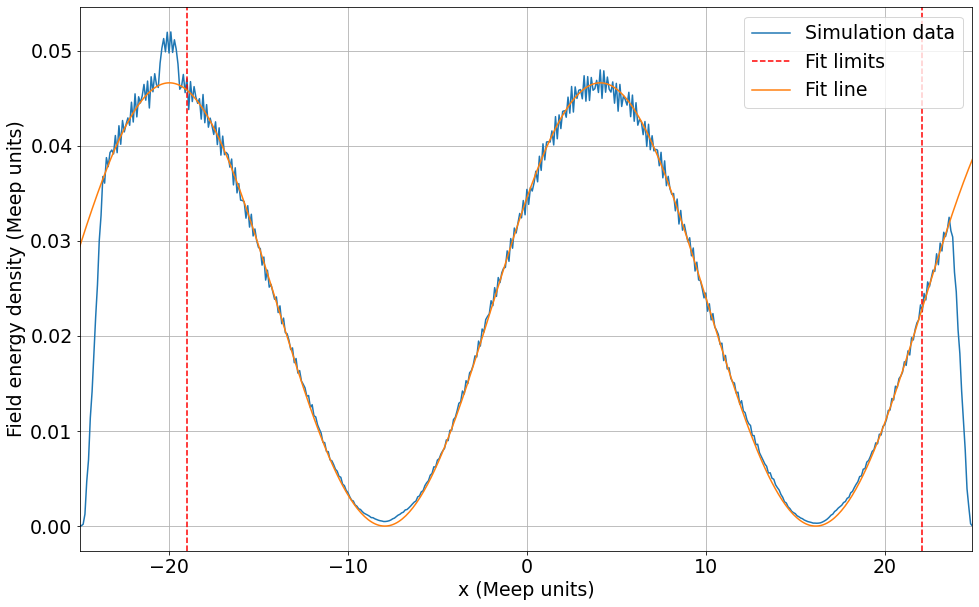

In [ ]:
# Plot of goodness of fit

fig = plt.figure(figsize = [16,10])
ax=plt.axes()

plt.plot(xvals_ed, EnergyDensity, label = "Simulation data")
plt.xlim(min(xvals_ed), max(xvals_ed))
#plt.xscale('log')
#plt.ylim(0.8,2)

# Vertical line at last point fitted
ax.axvline(xvals[startfit], color="r", ls="--", label="Fit limits")
ax.axvline(xvals[endfit], color="r", ls="--")

# Plotting the model
plt.plot(xvals, model(xvals,*fit[0]), label = "Fit line")
plt.grid()
plt.xlabel("x (Meep units)")
plt.ylabel("Field energy density (Meep units)")
plt.legend()
plt.savefig("energyDensityCoupler.svg", format = "svg", bbox_inches='tight')

plt.show()